In [12]:
!pip install implicit
!pip install tqdm

In [2]:
import pandas as pd
import requests
import time
import re
import logging
import os
from typing import List, Optional

In [3]:
# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.StreamHandler(),
        logging.FileHandler('script.log')
    ]
)
logger = logging.getLogger(__name__)

In [4]:
class MovieDataFetcher:
    def __init__(self, api_key: str, input_file: str, output_file: str):
        self.api_key = api_key
        self.input_file = input_file
        self.output_file = output_file
        self.checkpoint_file = 'checkpoint.txt'
        self.movies_df = pd.read_csv(input_file)
        self.start_index = self._load_checkpoint()

        # Initialize or load the output DataFrame
        if os.path.exists(self.output_file):
            self.processed_df = pd.read_csv(self.output_file)
            logger.info(f"Loaded existing output file with {len(self.processed_df)} entries")
        else:
            self.processed_df = pd.DataFrame(columns=self.movies_df.columns.tolist() + ['top_actors'])
            logger.info("Created new output DataFrame")

    def _load_checkpoint(self) -> int:
        """Load the checkpoint or return 0 if no checkpoint exists."""
        if os.path.exists(self.checkpoint_file):
            with open(self.checkpoint_file, 'r') as f:
                index = int(f.read().strip())
                logger.info(f"Resuming from index {index}")
                return index
        return 0

    def _save_checkpoint(self, index: int) -> None:
        """Save the current processing index to checkpoint file."""
        with open(self.checkpoint_file, 'w') as f:
            f.write(str(index))

    @staticmethod
    def extract_year(title: str) -> Optional[str]:
        """Extract year from movie title."""
        match = re.search(r'\((\d{4})\)', title)
        return match.group(1) if match else None

    def get_top_actors(self, movie_title: str, year: Optional[str]) -> List[str]:
        """Fetch top actors for a movie from TMDB API."""
        search_url = f"https://api.themoviedb.org/3/search/movie"
        params = {
            'api_key': self.api_key,
            'query': movie_title,
            'year': year
        }

        try:
            search_response = requests.get(search_url, params=params).json()

            if not search_response.get('results'):
                logger.warning(f"No results found for {movie_title} ({year})")
                return []

            movie_id = search_response['results'][0]['id']
            credits_url = f"https://api.themoviedb.org/3/movie/{movie_id}/credits"
            credits_params = {'api_key': self.api_key}

            credits_response = requests.get(credits_url, params=credits_params).json()
            top_actors = [actor['name'] for actor in credits_response.get('cast', [])[:5]]

            return top_actors

        except requests.exceptions.RequestException as e:
            logger.error(f"API request failed for {movie_title} ({year}): {e}")
            return []
        except KeyError as e:
            logger.error(f"Unexpected API response format for {movie_title} ({year}): {e}")
            return []

    def update_and_save_progress(self, index: int, row: pd.Series, top_actors: List[str]) -> None:
        """Update the processed DataFrame and save progress."""
        # Create a new row with all the original data plus top_actors
        new_row = row.to_dict()
        new_row['top_actors'] = ', '.join(top_actors)

        # If the index exists in processed_df, update it; otherwise append
        if index < len(self.processed_df):
            self.processed_df.loc[index] = new_row
        else:
            self.processed_df = pd.concat([self.processed_df, pd.DataFrame([new_row])], ignore_index=True)

        # Save to CSV
        self.processed_df.to_csv(self.output_file, index=False)
        logger.info(f"Saved progress for movie {index}: {row['title']}")

        # Update checkpoint
        self._save_checkpoint(index)

    def process_movies(self) -> None:
        """Process all movies and update the CSV file."""
        total_movies = len(self.movies_df)

        for index, row in self.movies_df.iterrows():
            if index < self.start_index:
                continue

            movie_title = row['title']
            year = self.extract_year(movie_title)
            movie_title_clean = re.sub(r'\(\d{4}\)', '', movie_title).strip()

            logger.info(f"Processing {index + 1}/{total_movies}: {movie_title_clean} ({year})")

            # Implement retry logic
            retries = 3
            top_actors = []

            for attempt in range(retries):
                try:
                    top_actors = self.get_top_actors(movie_title_clean, year)
                    if top_actors:
                        logger.info(f"Found actors for {movie_title_clean}: {', '.join(top_actors)}")
                        break
                    time.sleep(1)
                except Exception as e:
                    logger.warning(f"Attempt {attempt + 1} failed: {e}")
                    if attempt < retries - 1:
                        time.sleep(5)

            # Update the processed DataFrame and save progress
            self.update_and_save_progress(index, row, top_actors)

            # Respect API rate limits
            time.sleep(0.25)

In [5]:
def main():
    # Configuration
    API_KEY = '5fa8e2a358a75b3adf88bb6aaf916598'
    INPUT_FILE = 'movies_set1.csv'
    OUTPUT_FILE = 'movies_with_actors.csv'

    try:
        fetcher = MovieDataFetcher(API_KEY, INPUT_FILE, OUTPUT_FILE)
        fetcher.process_movies()
        logger.info("Processing completed successfully")
    except Exception as e:
        logger.error(f"Script failed: {e}")
        raise

if __name__ == "__main__":
    main()

2024-11-15 14:53:02,004 - INFO - Resuming from index 19999
2024-11-15 14:53:02,065 - INFO - Loaded existing output file with 20000 entries
2024-11-15 14:53:02,770 - INFO - Processing 20000/20000: Farmer Seeking Love (2022)
2024-11-15 14:53:03,099 - INFO - Found actors for Farmer Seeking Love: Donna Benedicto, Jesse Hutch, Tanya Clarke, Andrew Di Rosa, Jake Lewis
2024-11-15 14:53:03,183 - INFO - Saved progress for movie 19999: Farmer Seeking Love (2022)
2024-11-15 14:53:03,436 - INFO - Processing completed successfully


In [6]:
import pandas as pd

# Load the datasets
ratings_df = pd.read_csv('ratings_set1.csv')
movies_actors_df = pd.read_csv('movies_with_actors.csv')

In [7]:
# Merge the datasets on movieId
merged_df = pd.merge(ratings_df, movies_actors_df, on='movieId')

# Explode the top_actors column to have one actor per row
merged_df['top_actors'] = merged_df['top_actors'].str.split(', ')
exploded_df = merged_df.explode('top_actors')

In [8]:
# Group by userId and top_actors to calculate the average rating
user_actor_ratings = exploded_df.groupby(['userId', 'top_actors'])['rating'].mean().reset_index()

# Pivot the table to create the user-actor rating matrix
user_actor_matrix = user_actor_ratings.pivot(index='userId', columns='top_actors', values='rating')

# Fill NaN values with 0 (optional, depending on your use case)
user_actor_matrix = user_actor_matrix.fillna(0)

# Save the user-actor rating matrix to a CSV file
user_actor_matrix.to_csv('user_actor_ratings.csv')

print("User-actor rating matrix saved to 'user_actor_ratings.csv'")

User-actor rating matrix saved to 'user_actor_ratings.csv'


In [9]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix

from implicit.als import AlternatingLeastSquares
import pickle
from threadpoolctl import threadpool_limits

/home/dadi/Desktop/data_analytics/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
# Set OpenBLAS to use single thread to avoid performance issues
with threadpool_limits(limits=1, user_api='blas'):

    def load_and_prepare_data(filepath):
        """Load and prepare the user-actor rating matrix."""
        # Load the user-actor rating matrix
        user_actor_matrix = pd.read_csv(filepath, index_col=0)

        # Convert the DataFrame to a sparse matrix format suitable for implicit
        user_actor_matrix = user_actor_matrix.fillna(0)

        # Convert to CSR matrix
        sparse_matrix = csr_matrix(user_actor_matrix.values)

        return user_actor_matrix, sparse_matrix

In [11]:
    def train_model(sparse_matrix, factors=100, regularization=0.05, iterations=30):
        """Train the ALS model."""
        model = AlternatingLeastSquares(
            factors=factors,
            regularization=regularization,
            iterations=iterations
        )

        # Train the model
        model.fit(sparse_matrix)
        return model

In [12]:
    def get_top_n_recommendations(model, user_id, user_actor_matrix, sparse_matrix, n=10):
            """Get top N actor recommendations for a user."""
            try:
                # Get the user's index
                if user_id not in user_actor_matrix.index:
                    raise ValueError(f"User ID {user_id} not found in the dataset")

                user_index = user_actor_matrix.index.get_loc(user_id)

                # Get recommendations
                ids, scores = model.recommend(
                    userid=user_index,
                    user_items=sparse_matrix[user_index],
                    N=n,
                    filter_already_liked_items=True
                )

                # Get actor names if they're in your columns
                actor_names = user_actor_matrix.columns[ids].tolist()

                # Create recommendations dictionary
                recommendations = {
                    'actor_indices': ids,
                    'scores': scores,
                    'actor_names': actor_names
                }

                return recommendations

            except Exception as e:
                print(f"Error getting recommendations: {str(e)}")
                return None

In [13]:
    def save_model(model, filepath='user_actor_model.pkl'):
            """Save the trained model to a file."""
            try:
                with open(filepath, 'wb') as f:
                    pickle.dump(model, f)
                print(f"Model successfully saved to '{filepath}'")
            except Exception as e:
                print(f"Error saving model: {str(e)}")

In [14]:
    def main():
            try:
                # Load and prepare data
                user_actor_matrix, sparse_matrix = load_and_prepare_data('user_actor_ratings.csv')

                # Train model
                model = train_model(sparse_matrix)

                # Example usage

                user_id = 5  # Replace with actual user ID
                user_id= int(input("Enter the user ID: "))
                recommendations = get_top_n_recommendations(
                    model,
                    user_id,
                    user_actor_matrix,
                    sparse_matrix,
                    n=10
                )

                if recommendations:
                    print("\nTop 10 recommended actors:")
                    for name, score in zip(recommendations['actor_names'], recommendations['scores']):
                        print(f"Actor: {name}, Score: {score:.4f}")

                    # Get relevant actors for evaluation
                    relevant_actors = user_actor_matrix.loc[user_id][user_actor_matrix.loc[user_id] > 0].index.tolist()
                    print(f"\nRelevant actors for user {user_id}: {relevant_actors}")

                # Save model
                save_model(model)

            except Exception as e:
                print(f"An error occurred: {str(e)}")

    if __name__ == "__main__":
        main()

/home/dadi/Desktop/data_analytics/venv/lib/python3.12/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 16 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()
100%|██████████| 30/30 [00:02<00:00, 10.49it/s]



Top 10 recommended actors:
Actor: Charles Durning, Score: 0.7033
Actor: Lorraine Bracco, Score: 0.6586
Actor: Dennis Quaid, Score: 0.6305
Actor: Bridget Fonda, Score: 0.6007
Actor: Kristin Scott Thomas, Score: 0.5894
Actor: Madeleine Stowe, Score: 0.5843
Actor: Paul Sorvino, Score: 0.5808
Actor: Talia Shire, Score: 0.5651
Actor: Ray Liotta, Score: 0.5638
Actor: Hugh Grant, Score: 0.5524

Relevant actors for user 130: ['Al Pacino', 'Aldo Giuffrè', 'Alec Guinness', 'Alexis Smith', 'Alfre Woodard', 'Amy Yasbeck', 'Angela Bassett', 'Anna Paquin', 'Antonio Banderas', 'Arnold Schwarzenegger', 'Brad Pitt', 'Bruce Ramsay', 'Cameron Diaz', 'Cathy Moriarty', 'Chazz Palminteri', 'Cheech Marin', "Chris O'Donnell", 'Christian Slater', 'Christopher Walken', 'Cliff Curtis', 'Clint Eastwood', 'Corin Redgrave', 'Cybill Shepherd', 'Daniel Day-Lewis', 'Daniel Roebuck', 'David Duchovny', 'Dee Wallace', 'Demi Moore', 'Dennis Hopper', 'Diane Keaton', 'Donald Sutherland', 'Drew Barrymore', 'Dylan Baker', 'E

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

class RecommenderEvaluator:
    def __init__(self, user_actor_matrix, test_size=0.2, random_state=42):
        """
        Initialize the evaluator with the user-actor matrix.
        """
        self.user_actor_matrix = user_actor_matrix
        self.test_size = test_size
        self.random_state = random_state
        self.train_matrix = None
        self.test_matrix = None
        self.model = None
        np.random.seed(random_state)

    def prepare_train_test_split(self):
        """Split the data into training and testing sets."""
        print("Preparing train-test split...")
        matrix_array = self.user_actor_matrix.values
        mask = np.random.rand(*matrix_array.shape) < (1 - self.test_size)

        train = matrix_array * mask
        test = matrix_array * ~mask

        self.train_matrix = pd.DataFrame(
            train,
            index=self.user_actor_matrix.index,
            columns=self.user_actor_matrix.columns
        )
        self.test_matrix = pd.DataFrame(
            test,
            index=self.user_actor_matrix.index,
            columns=self.user_actor_matrix.columns
        )

        return csr_matrix(train), csr_matrix(test)

    def train_model(self, factors=50, regularization=0.1, iterations=20):
        """Train the ALS model on the training data."""
        print("Training the ALS model...")
        train_sparse, _ = self.prepare_train_test_split()

        with threadpool_limits(limits=1, user_api='blas'):
            self.model = AlternatingLeastSquares(
                factors=factors,
                regularization=regularization,
                iterations=iterations
            )
            self.model.fit(train_sparse)

        print("Model training completed.")
        return self.model

    def get_recommendations(self, user_id, k=10):
        """Get recommendations for a user."""
        user_idx = self.train_matrix.index.get_loc(user_id)
        user_items = csr_matrix(self.train_matrix.loc[user_id].values.reshape(1, -1))

        try:
            recommended_ids, scores = self.model.recommend(
                userid=user_idx,
                user_items=user_items,
                N=k,
                filter_already_liked_items=True
            )
            return recommended_ids, scores
        except Exception as e:
            print(f"Error getting recommendations for user {user_id}: {str(e)}")
            return [], []

    def precision_at_k(self, user_id, k=10):
        """Calculate Precision@k for a user."""
        actual = set(self.test_matrix.columns[self.test_matrix.loc[user_id] > 0].tolist())

        if not actual:
            return 0.0

        recommended_ids, _ = self.get_recommendations(user_id, k)

        if len(recommended_ids) == 0:
            return 0.0

        predicted = set(self.train_matrix.columns[recommended_ids].tolist())

        return len(actual.intersection(predicted)) / k if k > 0 else 0.0

    def recall_at_k(self, user_id, k=10):
        """Calculate Recall@k for a user."""
        actual = set(self.test_matrix.columns[self.test_matrix.loc[user_id] > 0].tolist())

        if not actual:
            return 0.0

        recommended_ids, _ = self.get_recommendations(user_id, k)

        if len(recommended_ids) == 0:
            return 0.0

        predicted = set(self.train_matrix.columns[recommended_ids].tolist())

        return len(actual.intersection(predicted)) / len(actual) if len(actual) > 0 else 0.0

    def ndcg_at_k(self, user_id, k=10):
        """Calculate NDCG@k for a user."""
        actual_ratings = self.test_matrix.loc[user_id]
        actual_ratings = actual_ratings[actual_ratings > 0]

        if len(actual_ratings) == 0:
            return 0.0

        recommended_ids, scores = self.get_recommendations(user_id, k)

        if len(recommended_ids) == 0:
            return 0.0

        dcg = 0.0
        for i, item_id in enumerate(recommended_ids):
            item_name = self.train_matrix.columns[item_id]
            if item_name in actual_ratings.index:
                dcg += actual_ratings[item_name] / np.log2(i + 2)

        ideal_ratings = sorted(actual_ratings.values, reverse=True)[:k]
        idcg = sum(rating / np.log2(i + 2) for i, rating in enumerate(ideal_ratings))

        return dcg / idcg if idcg > 0 else 0.0

    def evaluate_model(self, k=10, sample_size=None):
        """Evaluate the model using all metrics."""
        if self.model is None:
            raise ValueError("Model needs to be trained first")

        users = self.user_actor_matrix.index.tolist()
        if sample_size and sample_size < len(users):
            users = np.random.choice(users, size=sample_size, replace=False)

        metrics = {
            f'precision@{k}': [],
            f'recall@{k}': [],
            f'ndcg@{k}': []
        }
            


        print("Evaluating model...")
        for user_id in tqdm(users, desc="Evaluating users"):
            try:
                metrics[f'precision@{k}'].append(self.precision_at_k(user_id, k))
                metrics[f'recall@{k}'].append(self.recall_at_k(user_id, k))
                metrics[f'ndcg@{k}'].append(self.ndcg_at_k(user_id, k))
            except Exception as e:
                print(f"Error evaluating user {user_id}: {str(e)}")
                continue

        return {
            metric: np.mean(scores) for metric, scores in metrics.items()
        }
    def visualize_top_rated_actors(evaluator, user_id, k=10):
        """Visualize the top-rated actors for a given user."""
        recommended_ids, scores = evaluator.get_recommendations(user_id, k)
        actor_names = evaluator.train_matrix.columns[recommended_ids]
        
        plt.figure(figsize=(10, 6))
        plt.barh(actor_names, scores, color='skyblue')
        plt.xlabel('Scores')
        plt.title(f'Top {k} Recommended Actors for User {user_id}')
        plt.gca().invert_yaxis()
        plt.show()

Loading data...
Initializing evaluator...
Training model...
Training the ALS model...
Preparing train-test split...


100%|██████████| 20/20 [00:01<00:00, 16.13it/s]


Model training completed.
Evaluating model...


Evaluating users: 100%|██████████| 7989/7989 [00:19<00:00, 406.50it/s]



Evaluation Results:
precision@10: 0.5481
recall@10: 0.3787
ndcg@10: 0.6319


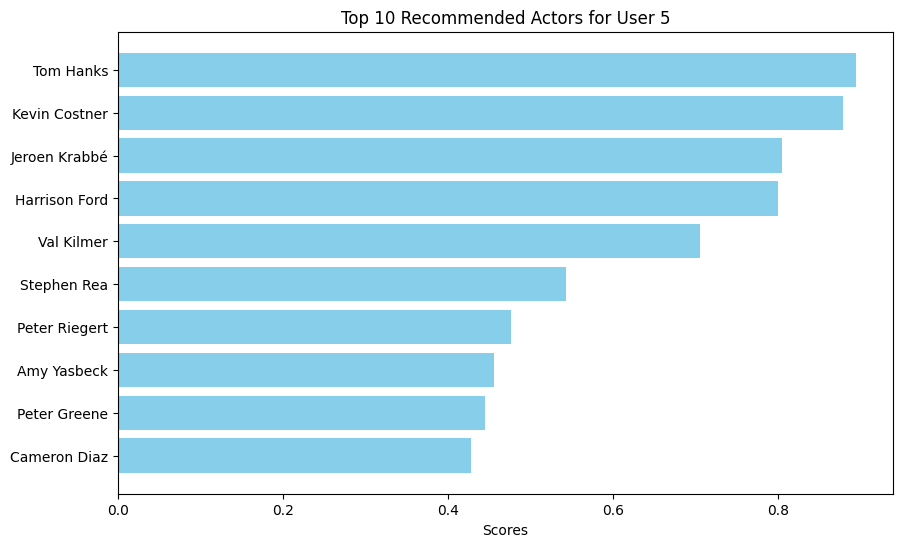


Evaluation and visualization completed.


In [18]:
from tqdm import tqdm
import pandas as pd
import numpy as np

def main():
    # Load data
    print("Loading data...")
    user_actor_matrix = pd.read_csv('user_actor_ratings.csv', index_col=0)

    # Initialize evaluator
    print("Initializing evaluator...")
    evaluator = RecommenderEvaluator(user_actor_matrix)

    # Train model
    print("Training model...")
    evaluator.train_model()

    # Evaluate model
    # print("\nEvaluating model...")
    # Use a smaller sample size for faster evaluation during testing
    metrics = evaluator.evaluate_model(k=10, sample_size=20000)  # Adjust sample_size as needed

    # Print results
    print("\nEvaluation Results:")
    for metric, score in metrics.items():
        print(f"{metric}: {score:.4f}")

    # Visualize top-rated actors for a user
    user_id = 5  
    evaluator.visualize_top_rated_actors(user_id, k=10)

    print("\nEvaluation and visualization completed.")



if __name__ == "__main__":
    main()